In [345]:
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
import re
import os
from IPython.display import Image 
import cv2
from tempfile import TemporaryFile
from scipy import stats
from torchvision import transforms
import pandas as pd
from matplotlib.font_manager import FontProperties
import shutil
import datetime
import glob
from scipy import integrate
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from PIL import ImageFile, Image
import sys
sys.path.insert(1, '../architecture')
sys.path.insert(2, '../dataLoaders')
from ProUNet import *
import torchvision.models as models
from MapillaryDataLoader import *
from volvoDataLoader_onFly import *
from VolvoDataLoader import *
from tqdm import tqdm
from torchsummary import summary
#from MapRSCD import *
%matplotlib inline

In [2]:
transform_in = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4191, 0.4586, 0.4700], [0.2553, 0.2675, 0.2945]),
    transforms.Resize((256,256))
])
transform_ou = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256))
])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.2553, 1/0.2675, 1/0.2945 ]),
                                transforms.Normalize(mean = [ -0.4191, -0.4586, -0.4700 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [3]:
#mapil_tr = MapRSCD(datasetRootPath = '../../../datasets/augmented_mapillary', mapillaryConfigFileAdd = "../../../datasets/mapillary", mode = 'train', imgSize = (256,256))
args = {
    "mode":"train",
    "input_img_dim":(256,256),
    "mapillaryRootPath":'../../../datasets/augmented_mapillary',
    "cityscapesRootPath":'../../../datasets/augmented_cityscapes',
    "RSCDRootPath":'../../../datasets/RSCD',
    "volvoRootPath":"../../../datasets/VolvoAnnotatedImages/rawDataset/images",
    "reducedCategories":True
}

dataloader = volvo_onFly(**args)

In [4]:
device = torch.device('cuda:0')
model = ProUNet(gecoConfig = {"enable":False}, device = device, num_classes = dataloader.get_num_classes(), LatentVarSize = 6, beta = 3, training = True, num_samples = 16).to(device)
check = torch.load("../checkpoints/HVAEFri_volvo_onTheFly_crf3/best.pth", map_location=device)
# check = torch.load("../../HVAEFri/checkpoints/HVAEFri_TrueObj/best.pth", map_location=device)
model.load_state_dict(check['model_state_dict'])

<All keys matched successfully>

In [437]:
img_idx = [100, 84, 2850, 2750, 120]
img_idx = [336, 84, 1500, 2950, 2994]

In [438]:
MeanSegs = []
frics = []
imgs = []
masks = []
friLabels = []

for idx in img_idx:
    sample = dataloader[idx]
    imgs.append(sample["image"])
    masks.append(sample["seg"])
    friLabels.append(sample["FriLabel"])
    segs, _, samplesFri = model.inference(sample["image"].to(device).unsqueeze(0))
    
    MeanSegs.append(torch.mean(segs, 0).squeeze().cpu())

    fri = torch.mean(samplesFri, 0).to("cpu")
    for classID in [0,2,5]: fri = torch.where(torch.argmax(sample["label"], axis = 0).unsqueeze(0) == classID, 0, fri)
    frics.append(torch.mean(fri, 0).squeeze().cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


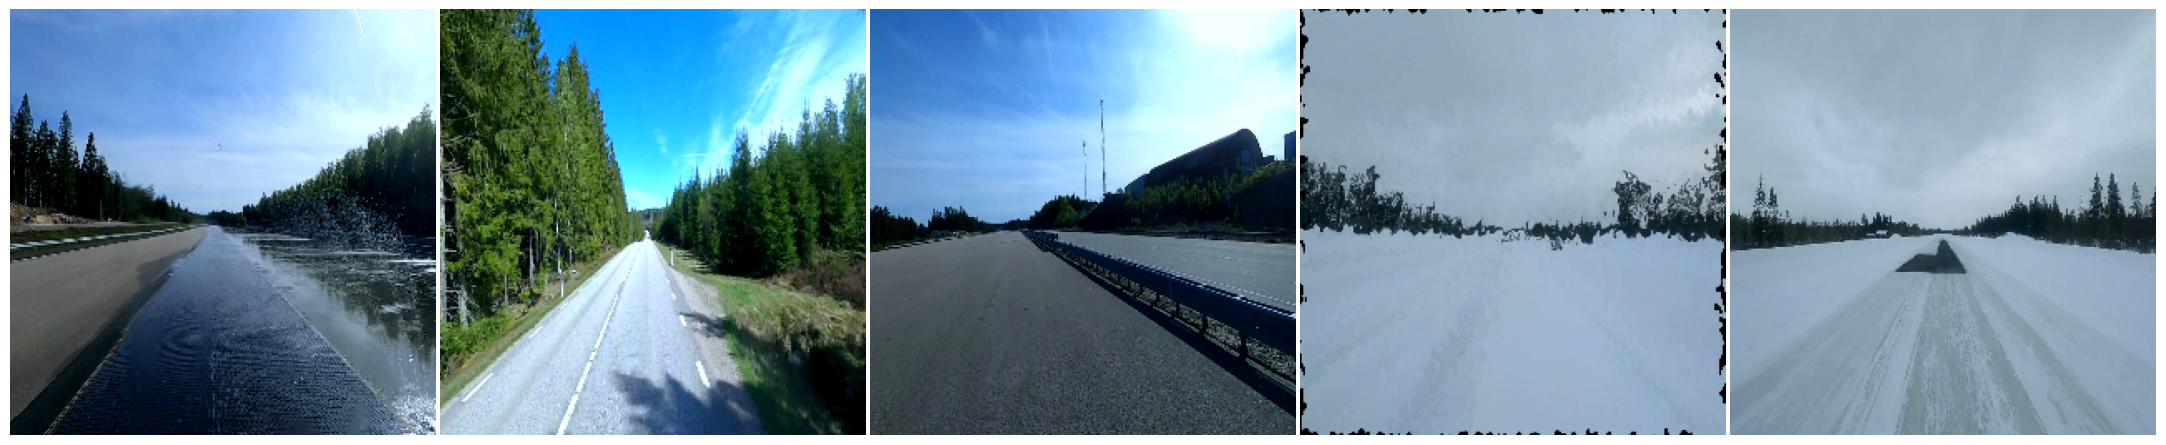

In [439]:
f, axarr = plt.subplots(1,5, figsize=(22, 20), dpi=100)
plt.rcParams.update({'font.size': 18})

for ax in axarr.reshape(-1):
    ax.axis('off')

axarr[0].imshow(invTrans(imgs[0]).permute(1,2,0))

axarr[1].imshow(invTrans(imgs[1]).permute(1,2,0))

axarr[2].imshow(invTrans(imgs[2]).permute(1,2,0))

axarr[3].imshow(invTrans(imgs[3]).permute(1,2,0))

axarr[4].imshow(invTrans(imgs[4]).permute(1,2,0))

plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0)
# plt.savefig('./pics/input_sample.png', bbox_inches='tight', dpi=300)

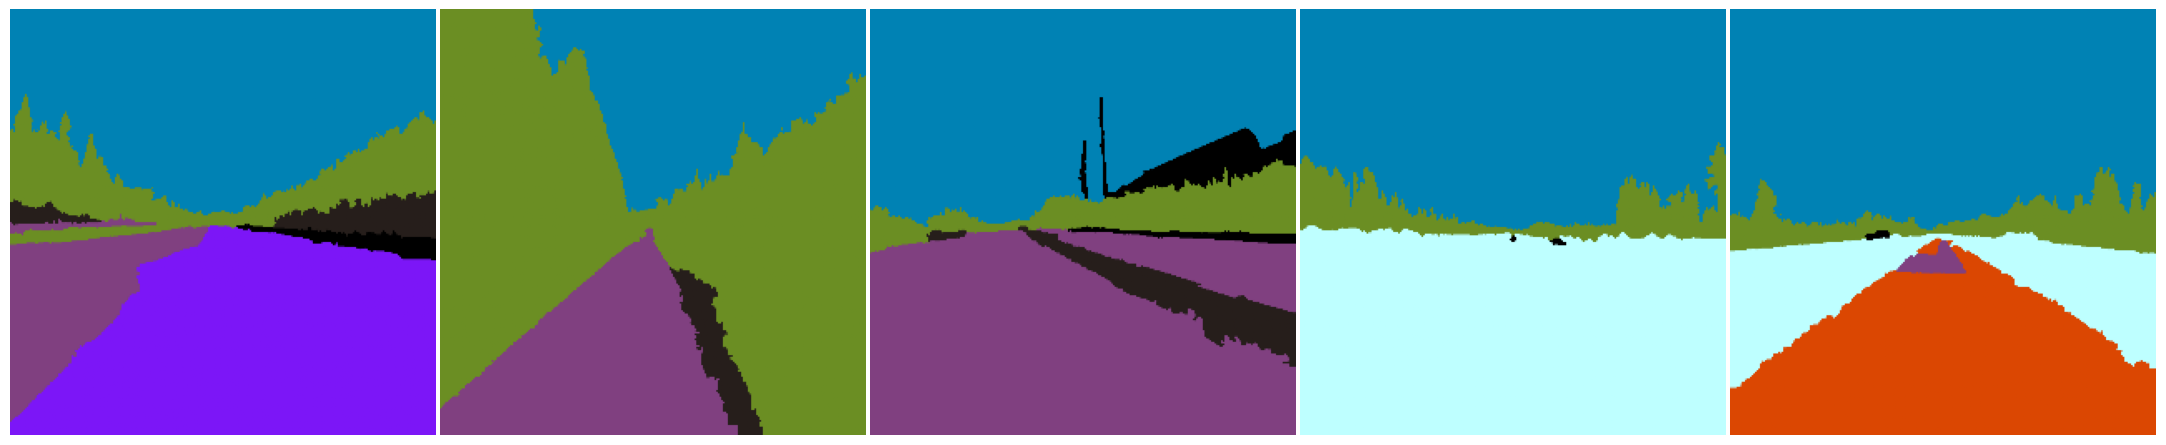

In [440]:
f, axarr = plt.subplots(1,5, figsize=(22, 20), dpi=100)

plt.rcParams.update({'font.size': 18})

for ax in axarr.reshape(-1):
    ax.axis('off')
    

axarr[0].imshow(masks[0].permute(1,2,0)) 

axarr[1].imshow(masks[1].permute(1,2,0))

axarr[2].imshow(masks[2].permute(1,2,0))

axarr[3].imshow(masks[3].permute(1,2,0))

axarr[4].imshow(masks[4].permute(1,2,0))
 

plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0)

# plt.savefig('./pics/seg_mask_sample.png', bbox_inches='tight', dpi=300)

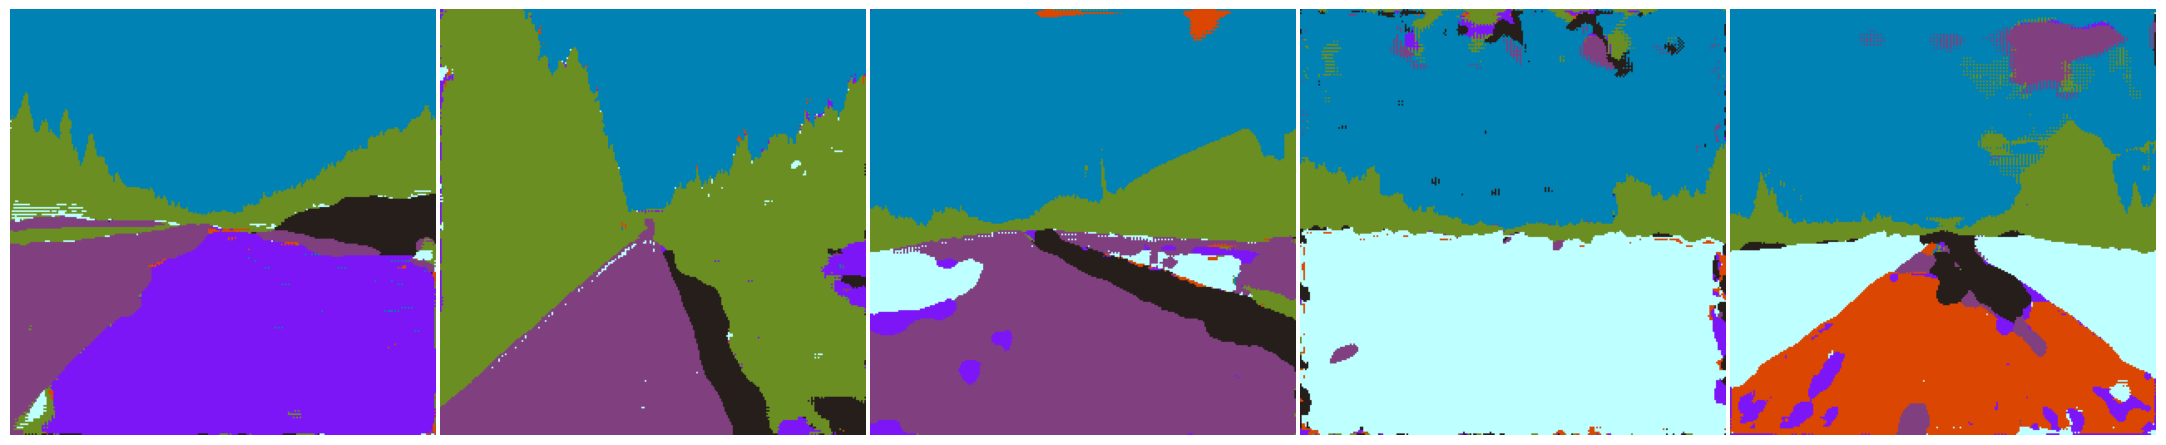

In [441]:
f, axarr = plt.subplots(1,5, figsize=(22, 20), dpi=100)
plt.rcParams.update({'font.size': 18})

for ax in axarr.reshape(-1):
    ax.axis('off')

axarr[0].imshow(dataloader.prMask_to_color(MeanSegs[0].unsqueeze(0)).squeeze(0).permute(1,2,0))

axarr[1].imshow(dataloader.prMask_to_color(MeanSegs[1].unsqueeze(0)).squeeze(0).permute(1,2,0))

axarr[2].imshow(dataloader.prMask_to_color(MeanSegs[2].unsqueeze(0)).squeeze(0).permute(1,2,0))

axarr[3].imshow(dataloader.prMask_to_color(MeanSegs[3].unsqueeze(0)).squeeze(0).permute(1,2,0))

axarr[4].imshow(dataloader.prMask_to_color(MeanSegs[4].unsqueeze(0)).squeeze(0).permute(1,2,0))

plt.tight_layout()
plt.subplots_adjust(wspace=0.01, hspace=0)
# plt.savefig('./pics/seg_pred_sample.png', bbox_inches='tight', dpi=300)

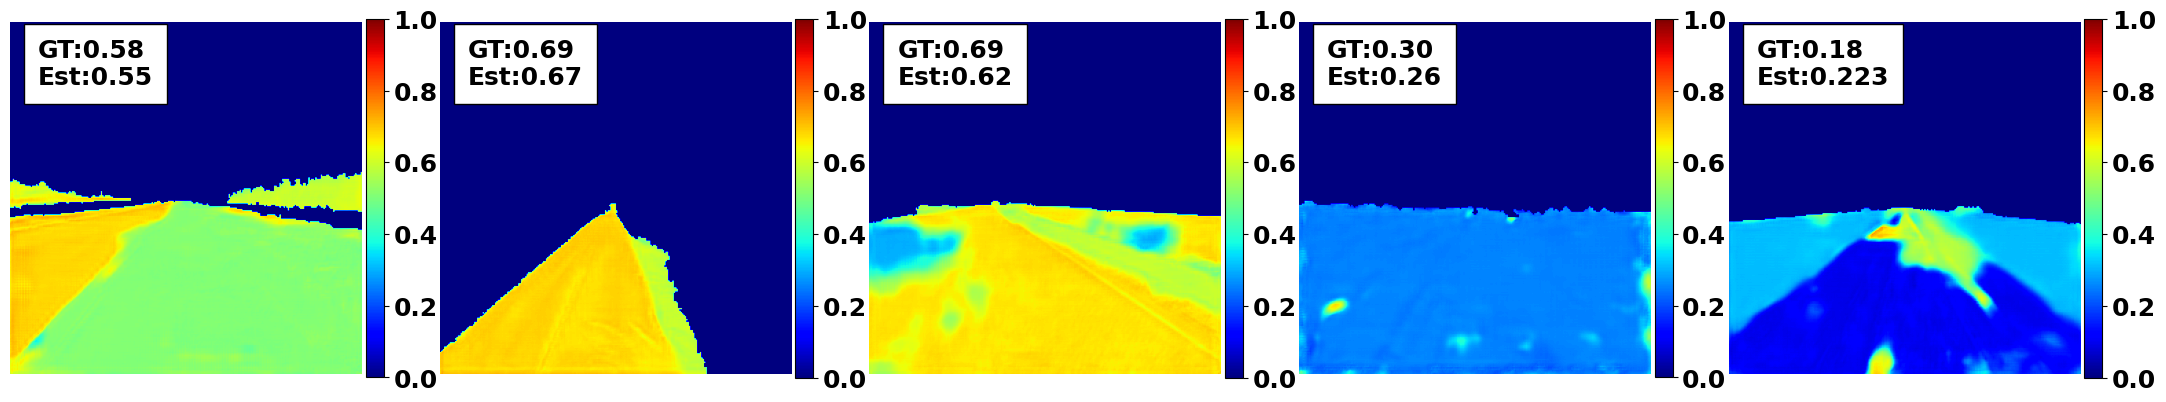

In [442]:
f, axarr = plt.subplots(1,5, figsize=(22, 20), dpi=100)
plt.rcParams.update({'font.size': 18})

for ax in axarr.reshape(-1):
    ax.axis('off')

cmap = plt.get_cmap('jet')
im = axarr[0].imshow(frics[0].squeeze(), cmap = cmap, vmin=frics[0].min(), vmax=1.)
axarr[0].text(20, 45, f'GT:{friLabels[0][friLabels[0]!=0].mean():.2f}\nEst:{frics[0][frics[0]!=0].mean():.2f}', bbox={'facecolor': 'white', 'pad': 10})
cbar = f.colorbar(im, ax=axarr[0], fraction=0.048, pad=0.01)

cmap = plt.get_cmap('jet')
im = axarr[1].imshow(frics[1].squeeze(), cmap = cmap, vmin=0., vmax=1.)
axarr[1].text(20, 45, f'GT:{friLabels[1][friLabels[1]!=0].mean():.2f}\nEst:{frics[1][frics[1]!=0].mean():.2f}', bbox={'facecolor': 'white', 'pad': 10})
cbar = f.colorbar(im, ax=axarr[1], fraction=0.048, pad=0.01)

cmap = plt.get_cmap('jet')
im = axarr[2].imshow(frics[2].squeeze(), cmap = cmap, vmin=0., vmax=1.)
axarr[2].text(20, 45, f'GT:{friLabels[2][friLabels[2]!=0].mean():.2f}\nEst:{frics[2][frics[2]!=0].mean():.2f}', bbox={'facecolor': 'white', 'pad': 10})
cbar = f.colorbar(im, ax=axarr[2], fraction=0.048, pad=0.01)

cmap = plt.get_cmap('jet')
im = axarr[3].imshow(frics[3].squeeze(), cmap = cmap, vmin=0., vmax=1.)
axarr[3].text(20, 45, f'GT:{friLabels[3][friLabels[3]!=0].mean():.2f}\nEst:{frics[3][frics[3]!=0].mean():.2f}', bbox={'facecolor': 'white', 'pad': 10})
cbar = f.colorbar(im, ax=axarr[3], fraction=0.048, pad=0.01)

cmap = plt.get_cmap('jet')
im = axarr[4].imshow(frics[4].squeeze(), cmap = cmap, vmin=0., vmax=1.)
axarr[4].text(20, 45, f'GT:{friLabels[4][friLabels[4]!=0].mean():.2f}\nEst:{frics[4][frics[4]!=0].mean():.3f}', bbox={'facecolor': 'white', 'pad': 10})
cbar = f.colorbar(im, ax=axarr[4], fraction=0.048, pad=0.01)


plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0)
# plt.savefig('./pics/fri_pred_sample.png', bbox_inches='tight', dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


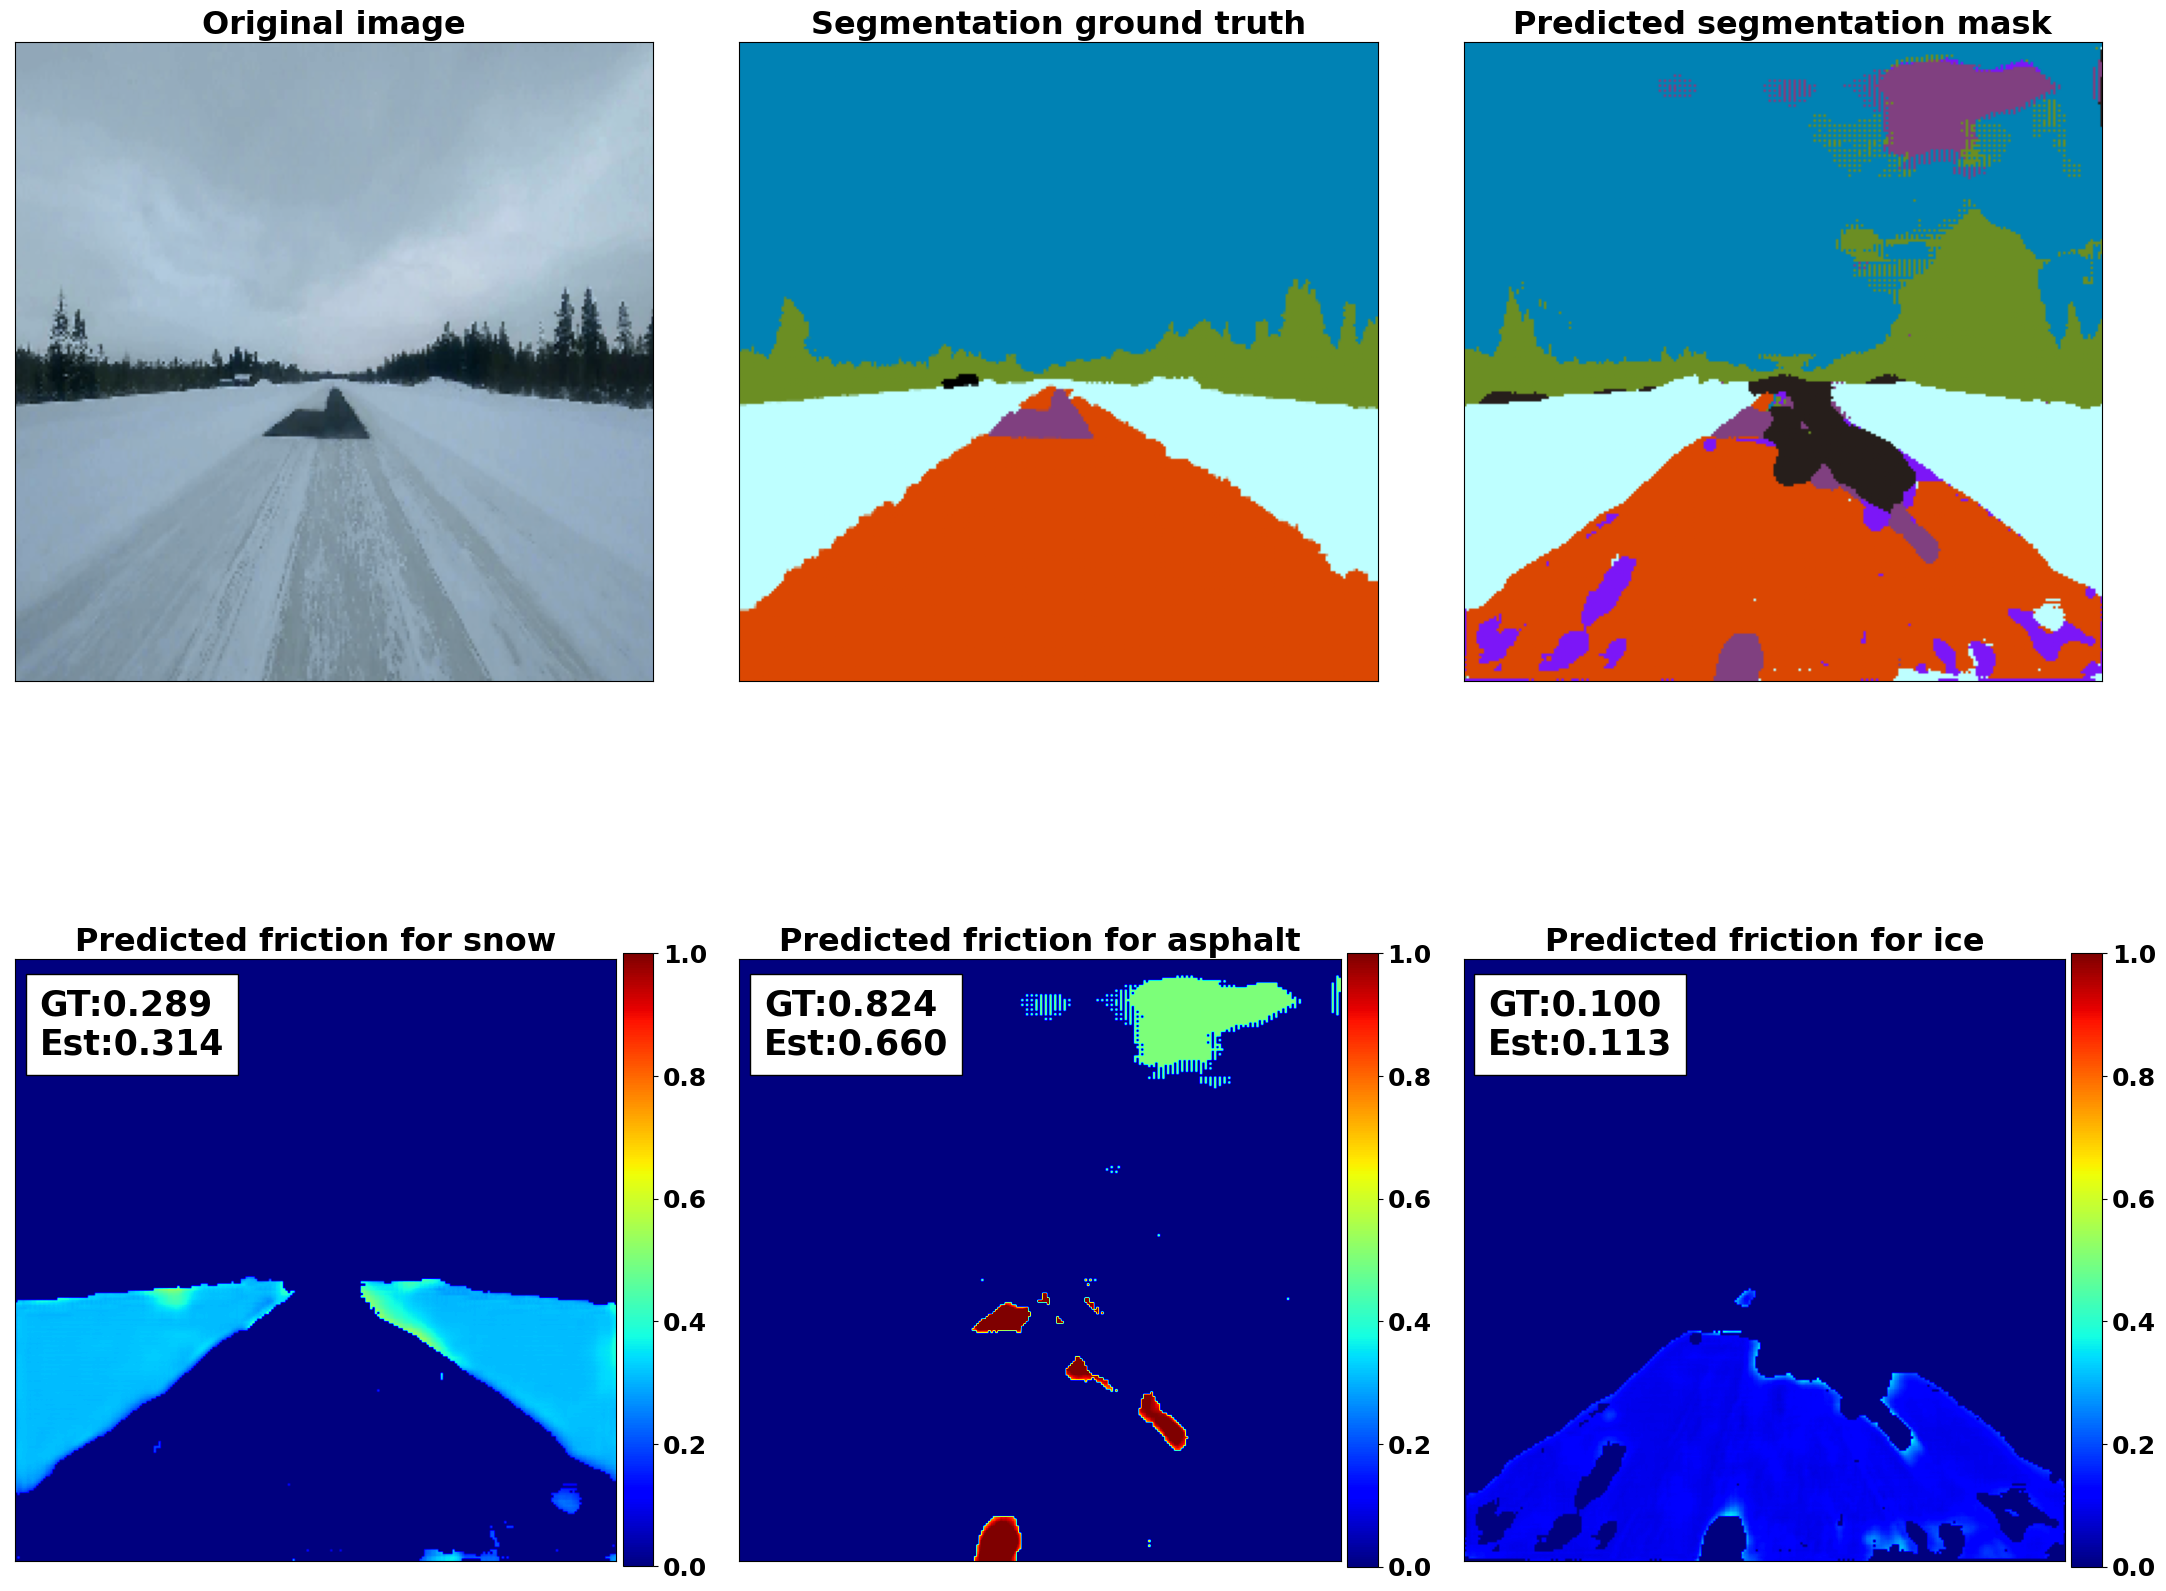

In [496]:
f, axarr = plt.subplots(2,3, figsize=(22, 20), dpi=100)
font_properties = FontProperties(weight='bold', size=23)


for ax in axarr.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])


axarr[0,0].imshow(invTrans(imgs[4]).permute(1,2,0))
axarr[0,0].title.set_text("Original image")
axarr[0, 0].title.set_fontproperties(font_properties)
axarr[0,1].imshow(masks[4].permute(1,2,0))
axarr[0,1].title.set_text("Segmentation ground truth")
axarr[0,1].title.set_fontproperties(font_properties)
axarr[0,2].imshow(dataloader.prMask_to_color(MeanSegs[4].unsqueeze(0)).squeeze(0).permute(1,2,0))
axarr[0,2].title.set_text("Predicted segmentation mask")
axarr[0,2].title.set_fontproperties(font_properties)


cmap = plt.get_cmap('jet')
tmp1 = frics[4].clone()
gth_tmp = friLabels[4].clone().squeeze(0)
tmp1[~(torch.argmax(MeanSegs[4], dim=0) == 3)] = 0
gth_tmp[~(torch.argmax(MeanSegs[4], dim=0) == 3)] = 0
im = axarr[1,0].imshow(tmp1, cmap = cmap, vmin=0., vmax=1.)
axarr[1,0].text(10, 40, f'GT:{gth_tmp[gth_tmp!=0].mean():.3f}\nEst:{tmp1[tmp1!=0].mean():.3f}', fontsize=25, bbox={'facecolor': 'white', 'pad': 10})
cbar = f.colorbar(im, ax=axarr[1,0], fraction=0.048, pad=0.01)
axarr[1,0].title.set_text("Predicted friction for snow")
axarr[1, 0].title.set_fontproperties(font_properties)



cmap2 = plt.get_cmap('jet')
tmp2 = frics[4].clone() + 0.5
gth_tmp2 = friLabels[4].clone().squeeze(0) + 0.75
tmp2[~(torch.argmax(MeanSegs[4], dim=0) == 1)] = 0
gth_tmp2[~(torch.argmax(MeanSegs[4], dim=0) == 1)] = 0
im = axarr[1,1].imshow(tmp2, cmap = cmap2, vmin=0., vmax=1.)
axarr[1,1].text(10, 40, f'GT:{gth_tmp2[gth_tmp2!=0].mean():.3f}\nEst:{tmp2[tmp2!=0].mean():.3f}', fontsize=25 ,bbox={'facecolor': 'white', 'pad': 10})
cbar = f.colorbar(im, ax=axarr[1,1], fraction=0.048, pad=0.01)
axarr[1,1].title.set_text("Predicted friction for asphalt")
axarr[1, 1].title.set_fontproperties(font_properties)



cmap2 = plt.get_cmap('jet')
tmp2 = frics[4].clone()
gth_tmp2 = friLabels[4].clone().squeeze(0)
tmp2[~(torch.argmax(MeanSegs[4], dim=0) == 4)] = 0
gth_tmp2[~(torch.argmax(MeanSegs[4], dim=0) == 4)] = 0
im = axarr[1,2].imshow(tmp2, cmap = cmap2, vmin=0., vmax=1.)
axarr[1,2].text(10, 40, f'GT:{gth_tmp2[gth_tmp2!=0].mean():.3f}\nEst:{tmp2[tmp2!=0].mean():.3f}' , fontsize=25,  bbox={'facecolor': 'white', 'pad': 10})
cbar = f.colorbar(im, ax=axarr[1,2], fraction=0.048, pad=0.01)
axarr[1,2].title.set_text("Predicted friction for ice")
axarr[1, 2].title.set_fontproperties(font_properties)



f.tight_layout()
plt.savefig('./pics/fric_example.png', bbox_inches='tight', dpi=300)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


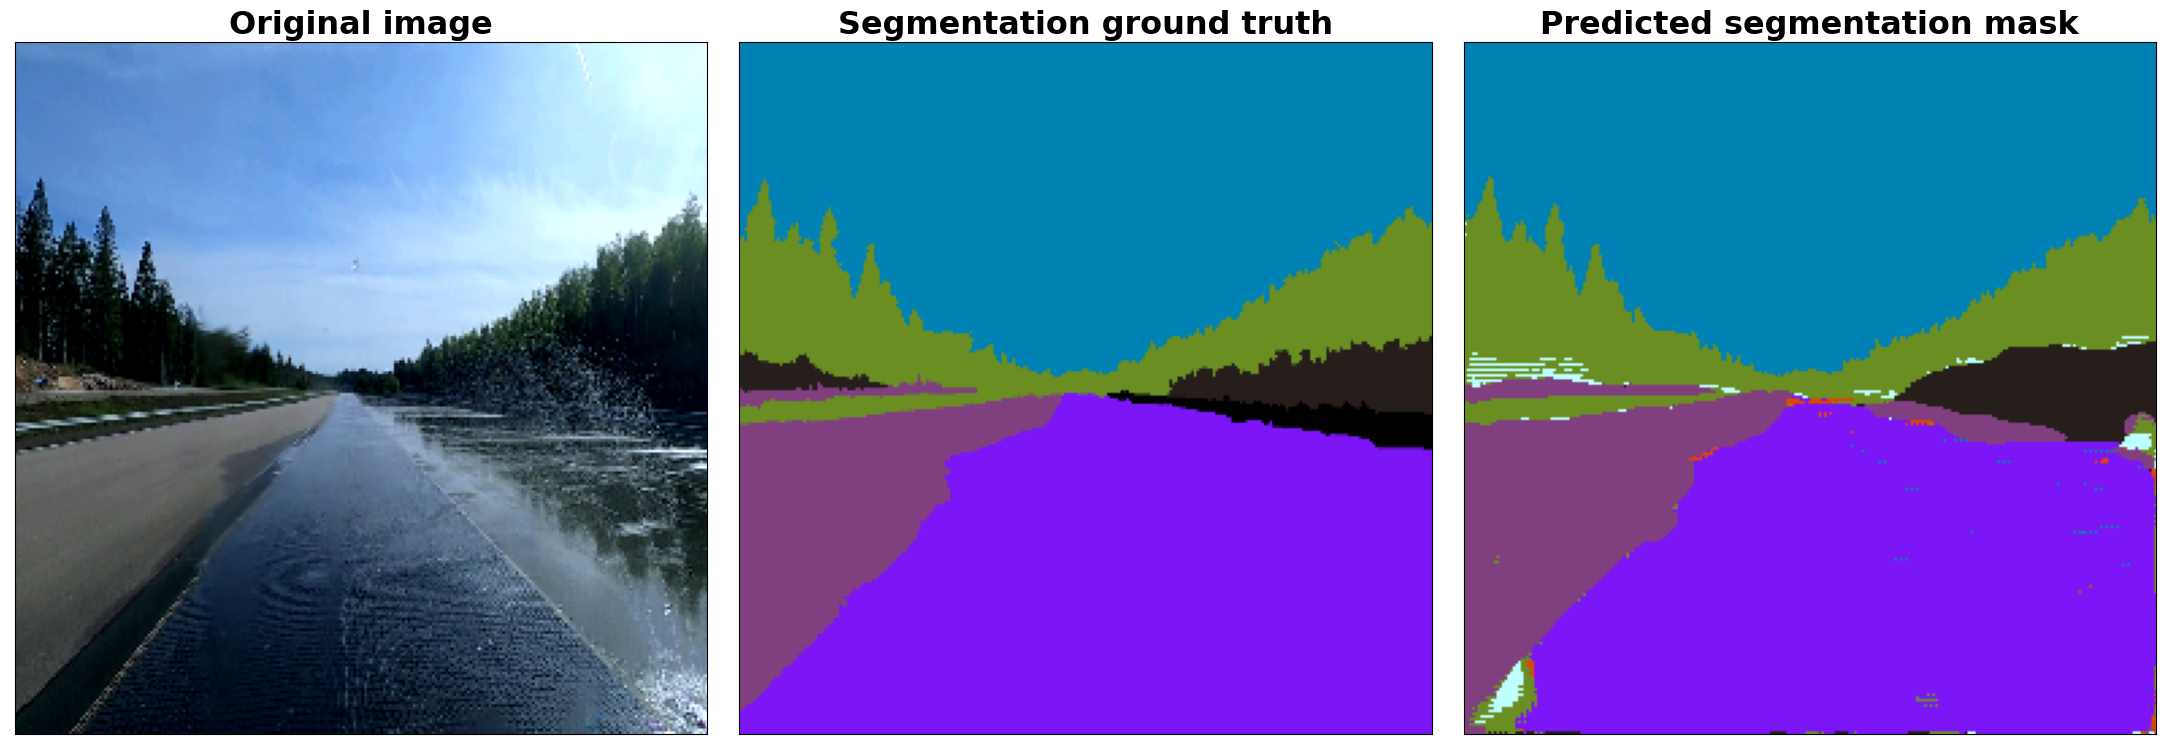

In [465]:
idx = 0
f, axarr = plt.subplots(1,3, figsize=(22, 20), dpi=100)
font_properties = FontProperties(weight='bold', size=23)


for ax in axarr.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])


axarr[0].imshow(invTrans(imgs[idx]).permute(1,2,0))
axarr[0].title.set_text("Original image")
axarr[0].title.set_fontproperties(font_properties)
axarr[1].imshow(masks[idx].permute(1,2,0))
axarr[1].title.set_text("Segmentation ground truth")
axarr[1].title.set_fontproperties(font_properties)
axarr[2].imshow(dataloader.prMask_to_color(MeanSegs[idx].unsqueeze(0)).squeeze(0).permute(1,2,0))
axarr[2].title.set_text("Predicted segmentation mask")
axarr[2].title.set_fontproperties(font_properties)






# cmap2 = plt.get_cmap('jet')
# tmp2 = frics[idx].clone()
# gth_tmp2 = friLabels[idx].clone().squeeze(0)
# tmp2[~(torch.argmax(MeanSegs[idx], dim=0) == 4)] = 0
# gth_tmp2[~(torch.argmax(MeanSegs[idx], dim=0) == 4)] = 0
# im = axarr[1,2].imshow(tmp2, cmap = cmap2, vmin=0., vmax=1.)
# axarr[1,2].text(20, 45, f'GT:{gth_tmp2[gth_tmp2!=0].mean():.3f}\nEst:{tmp2[tmp2!=0].mean():.3f}', bbox={'facecolor': 'white', 'pad': 10})
# cbar = f.colorbar(im, ax=axarr[1,2], fraction=0.048, pad=0.01)
# axarr[1,2].title.set_text("Predicted friction for ice")
# axarr[1, 2].title.set_fontproperties(font_properties)



f.tight_layout()
plt.savefig('./pics/fric_example_wet1.png', bbox_inches='tight', dpi=300)

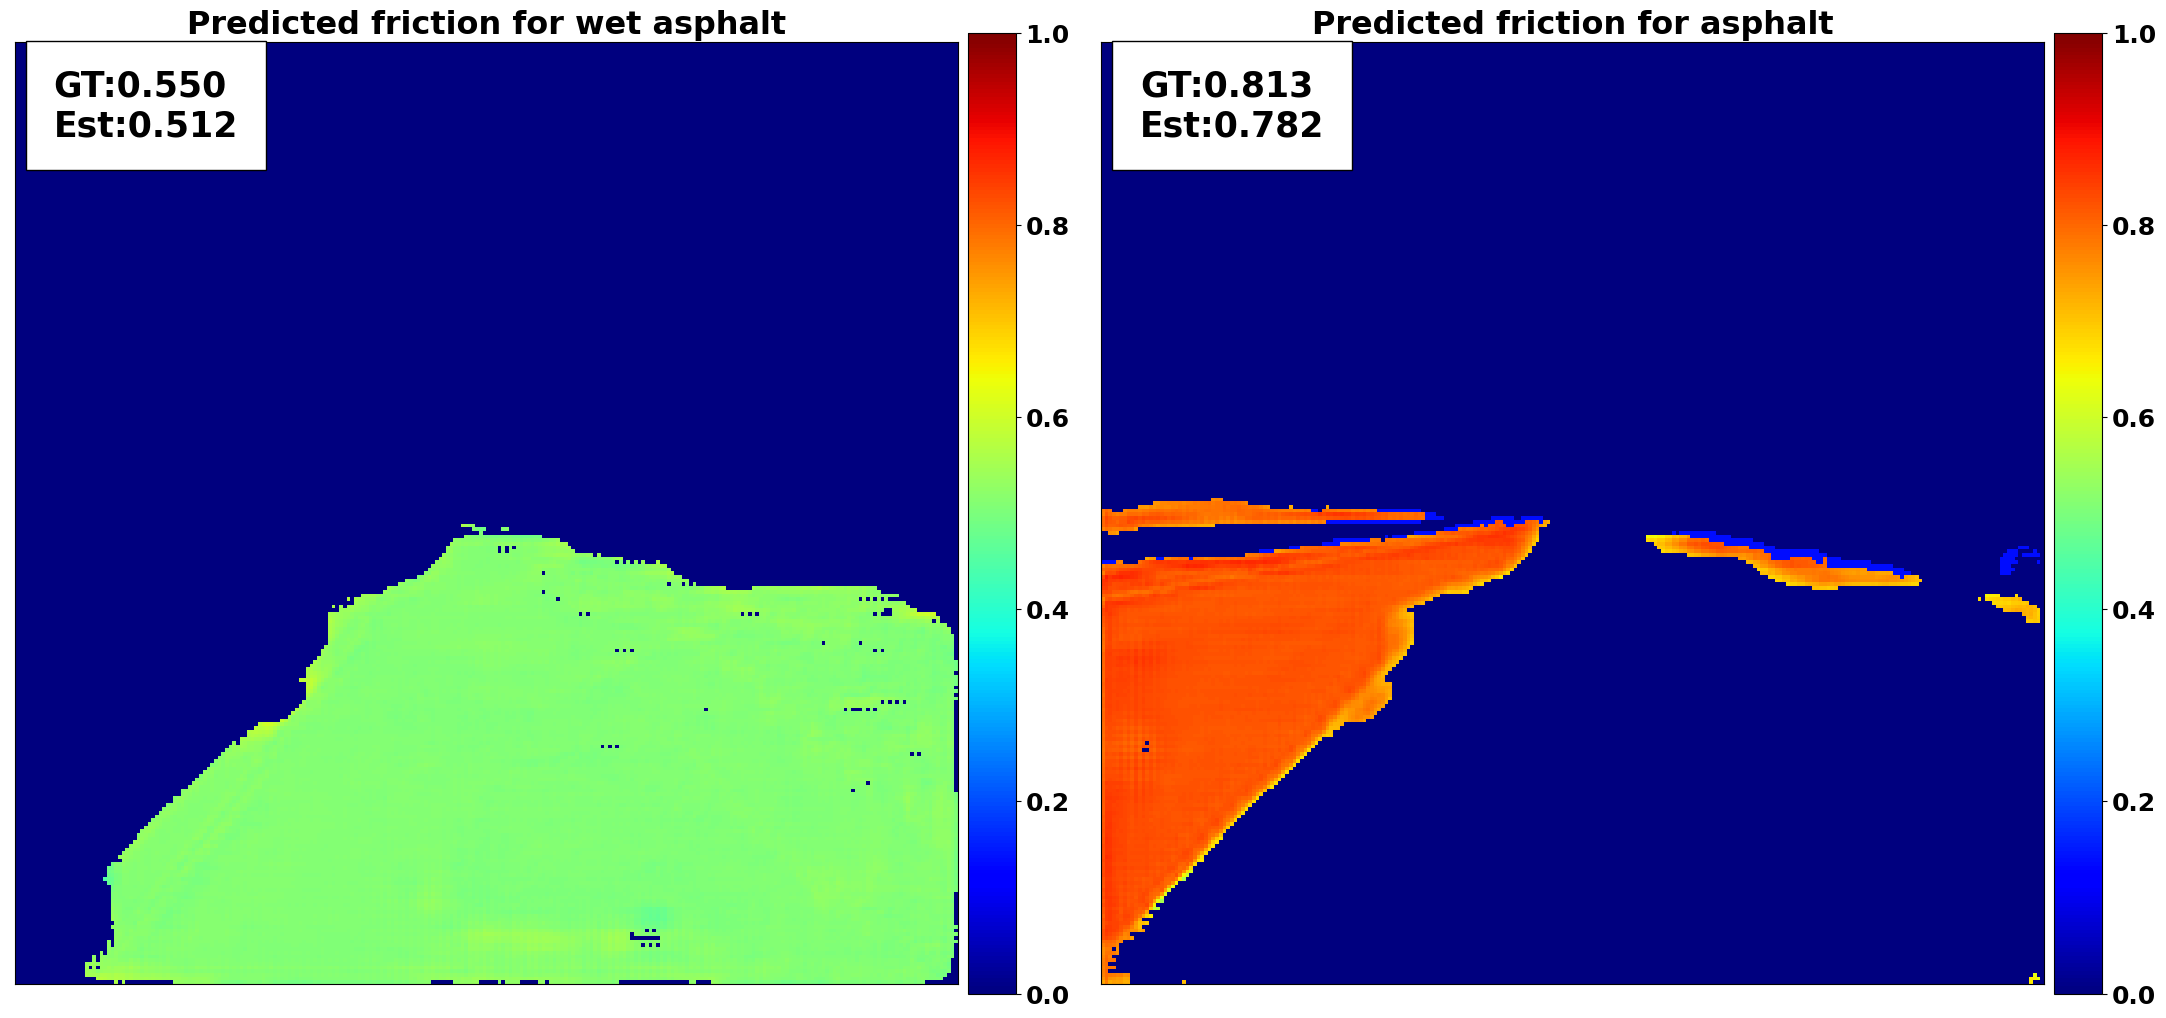

In [477]:
f, axarr = plt.subplots(1,2, figsize=(22, 20), dpi=100)

for ax in axarr.reshape(-1):
    ax.set_xticks([])
    ax.set_yticks([])

cmap = plt.get_cmap('jet')
tmp1 = frics[idx].clone()
gth_tmp = friLabels[idx].clone().squeeze(0)
tmp1[~(torch.argmax(MeanSegs[idx], dim=0) == 7)] = 0
gth_tmp[~(torch.argmax(MeanSegs[idx], dim=0) == 7)] = 0
im = axarr[0].imshow(tmp1, cmap = cmap, vmin=0., vmax=1.)
axarr[0].text(10, 25, f'GT:{gth_tmp[gth_tmp!=0].mean():.3f}\nEst:{tmp1[tmp1!=0].mean():.3f}', fontsize=25, bbox={'facecolor': 'white', 'pad': 20})
cbar = f.colorbar(im, ax=axarr[0], fraction=0.048, pad=0.01)
axarr[0].title.set_text("Predicted friction for wet asphalt")
axarr[0].title.set_fontproperties(font_properties)



cmap2 = plt.get_cmap('jet')
tmp2 = frics[idx].clone() + 0.14
gth_tmp2 = friLabels[idx].clone().squeeze(0) + 0.16
tmp2[~(torch.argmax(MeanSegs[idx], dim=0) == 1)] = 0
gth_tmp2[~(torch.argmax(MeanSegs[idx], dim=0) == 1)] = 0
im = axarr[1].imshow(tmp2, cmap = cmap2, vmin=0., vmax=1.)
axarr[1].text(10, 25, f'GT:{gth_tmp2[gth_tmp2!=0].mean():.3f}\nEst:{tmp2[tmp2!=0].mean():.3f}', fontsize=25, bbox={'facecolor': 'white', 'pad': 20})
cbar = f.colorbar(im, ax=axarr[1], fraction=0.048, pad=0.01)
axarr[1].title.set_text("Predicted friction for asphalt")
axarr[1].title.set_fontproperties(font_properties)

f.tight_layout()
plt.savefig('./pics/fric_example_wet2.png', bbox_inches='tight', dpi=300)